In [1]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

TEST_START_DATE = '2020-01-01'
TEST_END_DATE = '2021-12-31'


EIIE_MODEL = "trained_eiie/policy_EIIE_2019-12-31_4_2024-11-24 00_06_19.pt"

GRAPH_TITLE = "EIIE Trained 2009-04-01 to 2020-03-13, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3024, 8)


# Portfolio Optimization Algorithm

In [2]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df

environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.31764882 0.34307003 0.27757192 0.25526248 0.30967433 0.39883801
 0.32975733 0.28494525 0.37972005 0.2858634  0.25516213 0.32312584
 0.25988418 0.23875736 0.24494619 0.34357366 0.37968629 0.38037561
 0.50697334 0.29716349 0.46795714 0.40746618 0.3203123  0.27860261
 0.24718201 0.27592319 0.25638039 0.2211512  0.26665354 0.22214626
 0.18783522 0.35762632 0.22035591 0.23578814 0.30375372 0.52096129
 0.54083984 0.46436145 0.75169539 1.         0.8004436  0.74904598
 0.51388807 0.43978523 0.53029659 0.67230499 0.66889405 0.59927974
 0.98115871 0.86922229 0.75595789 0.75978523 0.70393097 0.63739936
 0.94181426 0.78955429 0.67414879 0.71182856 0.5910464  0.47880894
 0.3938393  0.46189304 0.41316358 0.38905067 0.30451807 0.47319031
 0.47569154 0.39599353 0.379

In [3]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_12212\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=

<All keys matched successfully>

In [4]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 3046547.75
Final accumulative portfolio value: 3.04654775
Maximum DrawDown: -0.33278222612735486
Sharpe ratio: 1.4684084857880653
Total commission cost: 206573.23550204397


In [5]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2020-03-13
1      8.525481e+05 2020-03-16
2      9.157950e+05 2020-03-17
3      8.877146e+05 2020-03-18
4      8.838433e+05 2020-03-19
..              ...        ...
450    3.069242e+06 2021-12-23
451    3.053464e+06 2021-12-27
452    3.097934e+06 2021-12-28
453    3.060822e+06 2021-12-29
454    3.046548e+06 2021-12-30

[455 rows x 2 columns]


In [6]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2020-03-13 00:00:00
2021-12-30 00:00:00


In [7]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(processed_test, new_opt_start_str,opt_end)

environment_benchmarks = PortfolioOptimizationEnv(
    test,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

# Porfolio Baselines

In [8]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1595944.25
Final accumulative portfolio value: 1.59594425
Maximum DrawDown: -0.18588675
Sharpe ratio: 1.0844055789529818
Total commission cost: 6908.112843277166
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2020-03-13
1         8.508769e+05 2020-03-16
2         9.022398e+05 2020-03-17
3         8.530465e+05 2020-03-18
4         8.440306e+05 2020-03-19
..                 ...        ...
450       1.580655e+06 2021-12-23
451       1.598314e+06 2021-12-27
452       1.603126e+06 2021-12-28
453       1.600972e+06 2021-12-29
454       1.595944e+06 2021-12-30

[455 rows x 2 columns]


In [9]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1583594.875
Final accumulative portfolio value: 1.583594875
Maximum DrawDown: -0.178662125
Sharpe ratio: 1.0808963372658327
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2020-03-13
1         8.508769e+05 2020-03-16
2         9.041880e+05 2020-03-17
3         8.605808e+05 2020-03-18
4         8.524382e+05 2020-03-19
..                 ...        ...
450       1.567346e+06 2021-12-23
451       1.589330e+06 2021-12-27
452       1.591297e+06 2021-12-28
453       1.590077e+06 2021-12-29
454       1.583595e+06 2021-12-30

[455 rows x 2 columns]


In [10]:


# BAH on each individual stock

BAH_results = {
    "test": {},
}

# Weights are in alphabetical order

# AAPL
model_kwargs_AAPL={
    "target_weights": np.array([0,1,0,0,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_AAPL)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_AAPL = pd.DataFrame(BAH_results["test"]["value"], columns=['AAPL_net_worth'])
df_bah_date_AAPL = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_AAPL['Date'] = df_bah_date['Date']


# "BA"
model_kwargs_BA={
    "target_weights": np.array([0,0,1,0,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_BA)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_BA = pd.DataFrame(BAH_results["test"]["value"], columns=['BA_net_worth'])
df_bah_date_BA = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_BA['Date'] = df_bah_date['Date']

# "INTC"
model_kwargs_INTC={
    "target_weights": np.array([0,0,0,1,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_INTC)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_INTC = pd.DataFrame(BAH_results["test"]["value"], columns=['INTC_net_worth'])
df_bah_date_INTC = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_INTC['Date'] = df_bah_date['Date']

# "MSFT"
model_kwargs_MSFT={
    "target_weights": np.array([0,0,0,0,1,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_MSFT)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_MSFT = pd.DataFrame(BAH_results["test"]["value"], columns=['MSFT_net_worth'])
df_bah_date_MSFT = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_MSFT['Date'] = df_bah_date['Date']

# "V"

model_kwargs_V={
    "target_weights": np.array([0,0,0,0,0,1,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_V)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_V = pd.DataFrame(BAH_results["test"]["value"], columns=['V_net_worth'])
df_bah_date_V = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_V['Date'] = df_bah_date['Date']

# WMT
model_kwargs_WMT={
    "target_weights": np.array([0,0,0,0,0,0,1])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_WMT)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_WMT = pd.DataFrame(BAH_results["test"]["value"], columns=['WMT_net_worth'])
df_bah_date_WMT = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_WMT['Date'] = df_bah_date['Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2596235.0
Final accumulative portfolio value: 2.596235
Maximum DrawDown: -0.20375617323136075
Sharpe ratio: 1.7111240906804814
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1191010.625
Final accumulative portfolio value: 1.191010625
Maximum DrawDown: -0.44177437500000005
Sharpe ratio: 0.4702076266656405
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 994578.6875
Final accumulative portfolio value: 0.9945786875
Maximum DrawDown: -0.30976744611548646
Sharpe ratio: 0.1971793945340725
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2171169.5
Final accumulative portfolio value: 2.1711695
Maximum DrawDown: -0.14739049999999998
Sharpe ratio: 1.552566774202658
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1252565.25
Final accumulative portfolio value: 1.25256525
Maximum DrawDown: -0.23980987891532168
Sharpe ratio: 0.5452105381264011
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1296010.625
Final accumulative portfolio value: 1.296010625
Maximum DrawDown: -0.16227377070344606
Sharpe ratio: 0.7402980351504932
Total commission cost: 0.0
hit end!


# Stock environment optimization algorithm

In [11]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (454, 8)
Annual return          0.286216
Cumulative returns     0.573761
Annual volatility      0.243181
Sharpe ratio           1.160031
Calmar ratio           1.444614
Stability              0.898820
Max drawdown          -0.198127
Omega ratio            1.276002
Sortino ratio          1.659757
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.024531
Daily value at risk   -0.029518
dtype: float64
df_dji:            date           dji
0   2020-03-13  1.000000e+06
1   2020-03-16  8.707345e+05
2   2020-03-17  9.159721e+05
3   2020-03-18  8.582441e+05
4   2020-03-19  8.663642e+05
..         ...           ...
450 2021-12-23  1.550554e+06
451 2021-12-27  1.565728e+06
452 2021-12-28  1.569862e+06
453 2021-12-29  1.573761e+06
454 2021-12-30           NaN

[455 rows x 2 columns]
df_dji:                       dji
date                    
2020-03-13  1.000000e+06
2020-03-16  8.707345e+05
2020-03-17  9.159721e+05
2020-03-18  8.582441e+05

# Compare all results

In [12]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt


# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge all stocks
df_bah_opt_AAPL['Date'] = pd.to_datetime(df_bah_opt_AAPL['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_AAPL, on='Date')

df_bah_opt_MSFT['Date'] = pd.to_datetime(df_bah_opt_MSFT['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_MSFT, on='Date')

df_bah_opt_V['Date'] = pd.to_datetime(df_bah_opt_V['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_V, on='Date')

df_bah_opt_WMT['Date'] = pd.to_datetime(df_bah_opt_WMT['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_WMT, on='Date')

df_bah_opt_BA['Date'] = pd.to_datetime(df_bah_opt_BA['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_BA, on='Date')

df_bah_opt_INTC['Date'] = pd.to_datetime(df_bah_opt_INTC['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_INTC, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2020-03-13  1.000000e+06
2020-03-16  8.707345e+05
2020-03-17  9.159721e+05
2020-03-18  8.582441e+05
2020-03-19  8.663642e+05
...                  ...
2021-12-23  1.550554e+06
2021-12-27  1.565728e+06
2021-12-28  1.569862e+06
2021-12-29  1.573761e+06
2021-12-30           NaN

[455 rows x 1 columns]
     crp_opt_net_worth       Date  bah_opt_net_worth  AAPL_net_worth  \
0         1.000000e+06 2020-03-13       1.000000e+06    1.000000e+06   
1         8.508769e+05 2020-03-16       8.508769e+05    8.713532e+05   
2         9.022398e+05 2020-03-17       9.041880e+05    9.096668e+05   
3         8.530465e+05 2020-03-18       8.605808e+05    8.873981e+05   
4         8.440306e+05 2020-03-19       8.524382e+05    8.805989e+05   
..                 ...        ...                ...             ...   
450       1.580655e+06 2021-12-23       1.567346e+06    2.568262e+06   
451       1.598314e+06 2021-12-27       1.589330e+06    2.627268e+06   
452

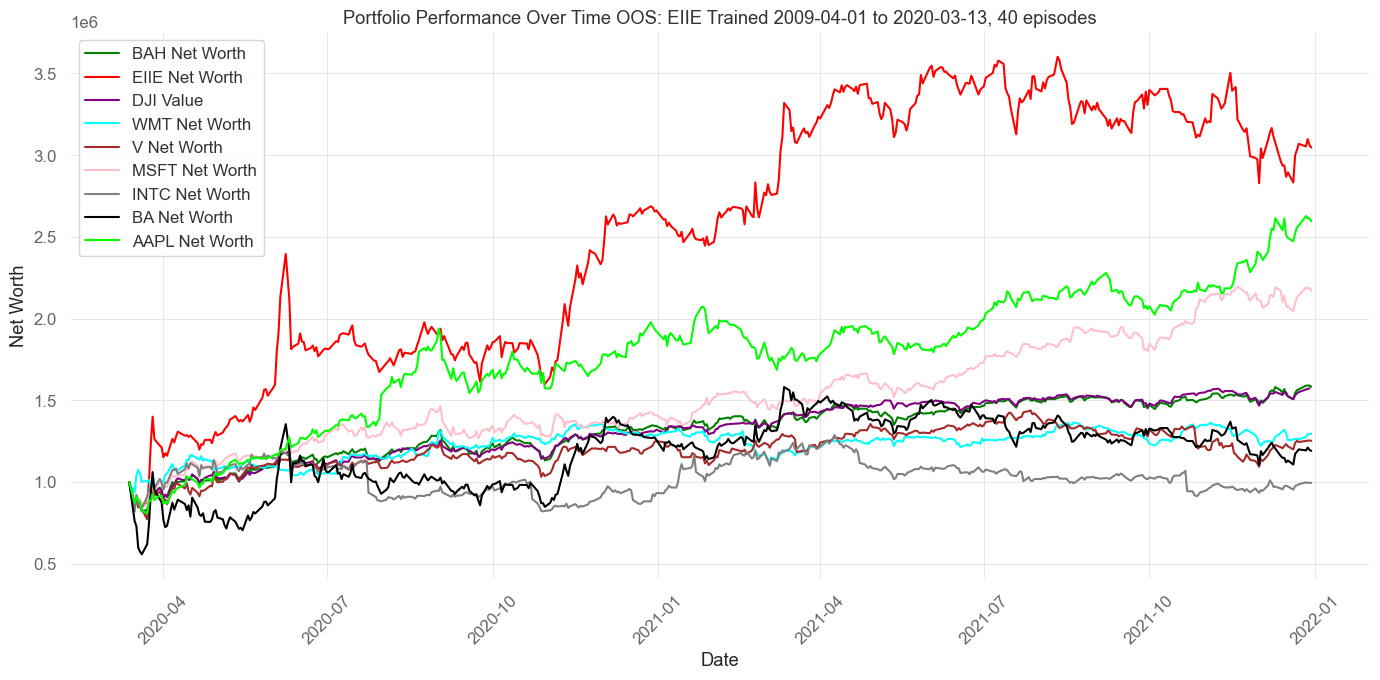

In [13]:
import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'EIIE Net Worth': 'red',
    'DJI Value': 'purple',
    'WMT Net Worth': 'cyan',
    'V Net Worth': 'brown',
    'MSFT Net Worth': 'pink',
    'INTC Net Worth': 'gray',
    'BA Net Worth': 'black',
    'AAPL Net Worth': 'lime'
}

# Plot 1: OOS Portfolio Performance
plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE Net Worth', color=color_map['EIIE Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.plot(merged_df['Date'], merged_df['WMT_net_worth'], label='WMT Net Worth', color=color_map['WMT Net Worth'])
plt.plot(merged_df['Date'], merged_df['V_net_worth'], label='V Net Worth', color=color_map['V Net Worth'])
plt.plot(merged_df['Date'], merged_df['MSFT_net_worth'], label='MSFT Net Worth', color=color_map['MSFT Net Worth'])
plt.plot(merged_df['Date'], merged_df['INTC_net_worth'], label='INTC Net Worth', color=color_map['INTC Net Worth'])
plt.plot(merged_df['Date'], merged_df['BA_net_worth'], label='BA Net Worth', color=color_map['BA Net Worth'])
plt.plot(merged_df['Date'], merged_df['AAPL_net_worth'], label='AAPL Net Worth', color=color_map['AAPL Net Worth'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [14]:
import pprint

final_returns = {
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'WMT': merged_df['WMT_net_worth'].iloc[-1],
    'V': merged_df['V_net_worth'].iloc[-1],
    'MSFT': merged_df['MSFT_net_worth'].iloc[-1],
    'AAPL': merged_df['AAPL_net_worth'].iloc[-1],
    'BA': merged_df['BA_net_worth'].iloc[-1],
    'INTC': merged_df['INTC_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'AAPL': 2596235.0,
 'BA': 1191010.625,
 'BAH': 1583594.875,
 'CRP': 1595944.25,
 'EIIE': 3046547.75,
 'INTC': 994578.6875,
 'MSFT': 2171169.5,
 'V': 1252565.25,
 'WMT': 1296010.625}


In [15]:
import numpy as np
import pprint


# Calculate daily returns for each specified portfolio
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()
merged_df['WMT_opt_daily_return'] = merged_df['WMT_net_worth'].pct_change()
merged_df['V_opt_daily_return'] = merged_df['V_net_worth'].pct_change()
merged_df['MSFT_opt_daily_return'] = merged_df['MSFT_net_worth'].pct_change()
merged_df['AAPL_opt_daily_return'] = merged_df['AAPL_net_worth'].pct_change()
merged_df['BA_opt_daily_return'] = merged_df['BA_net_worth'].pct_change()
merged_df['INTC_opt_daily_return'] = merged_df['INTC_net_worth'].pct_change()

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate the Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'].dropna(), risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'].dropna(), risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'].dropna(), risk_free_rate),
    'WMT': calculate_sharpe_ratio(merged_df['WMT_opt_daily_return'].dropna(), risk_free_rate),
    'V': calculate_sharpe_ratio(merged_df['V_opt_daily_return'].dropna(), risk_free_rate),
    'MSFT': calculate_sharpe_ratio(merged_df['MSFT_opt_daily_return'].dropna(), risk_free_rate),
    'AAPL': calculate_sharpe_ratio(merged_df['AAPL_opt_daily_return'].dropna(), risk_free_rate),
    'BA': calculate_sharpe_ratio(merged_df['BA_opt_daily_return'].dropna(), risk_free_rate),
    'INTC': calculate_sharpe_ratio(merged_df['INTC_opt_daily_return'].dropna(), risk_free_rate),

}


pprint.pprint(sharpe_ratios)

{'AAPL': 1.654886333529497,
 'BA': 0.4401674582079241,
 'BAH': 1.0080144151440062,
 'CRP': 1.0126207324879715,
 'EIIE': 1.4304992374349874,
 'INTC': 0.14736251643693016,
 'MSFT': 1.4892975541064686,
 'V': 0.48456003023705313,
 'WMT': 0.6538695577345035}


In [16]:
import numpy as np
import pandas as pd


# Define a function to calculate the max drawdown
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

# Calculate max drawdowns for each portfolio
max_drawdowns = {
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    'WMT': max_drawdown(merged_df['WMT_net_worth']),
    'V': max_drawdown(merged_df['V_net_worth']),
    'MSFT': max_drawdown(merged_df['MSFT_net_worth']),
    'AAPL': max_drawdown(merged_df['AAPL_net_worth']),
    'BA': max_drawdown(merged_df['BA_net_worth']),
    'INTC': max_drawdown(merged_df['INTC_net_worth']),
}

pprint.pprint(max_drawdowns)


{'AAPL': -0.20375617323136075,
 'BA': -0.44177437500000005,
 'BAH': -0.178662125,
 'CRP': -0.18588675,
 'EIIE': -0.33278222612735486,
 'INTC': -0.30976744611548646,
 'MSFT': -0.14739049999999998,
 'V': -0.23980987891532168,
 'WMT': -0.16227377070344606}


In [17]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'INTC': calculate_up_days_ratio(merged_df['INTC_opt_daily_return']),
    'WMT': calculate_up_days_ratio(merged_df['WMT_opt_daily_return']),
    'V': calculate_up_days_ratio(merged_df['V_opt_daily_return']),
    'MSFT': calculate_up_days_ratio(merged_df['MSFT_opt_daily_return']),
    'AAPL': calculate_up_days_ratio(merged_df['AAPL_opt_daily_return']),
    'BA': calculate_up_days_ratio(merged_df['BA_opt_daily_return']),
}

pprint.pprint(up_days_ratios)

{'AAPL': 0.5440528634361234,
 'BA': 0.4581497797356828,
 'BAH': 0.5770925110132159,
 'CRP': 0.5550660792951542,
 'EIIE': 0.5198237885462555,
 'INTC': 0.5110132158590308,
 'MSFT': 0.5484581497797357,
 'V': 0.5286343612334802,
 'WMT': 0.4955947136563877}


In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq     df         F    PR(>F)
Portfolio  0.000729    1.0  1.116836  0.290882
Residual   0.591046  906.0       NaN       NaN


In [19]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1     -0.149123
2      0.062654
3     -0.048228
4     -0.009462
5     -0.036484
         ...   
450    0.003173
451    0.014026
452    0.001237
453   -0.000767
454   -0.004077
Name: BAH_opt_daily_return, Length: 454, dtype: float64
t-statistic: 1.0568047920944166
p-value: 0.2908823901766869
